In [7]:
# Reproducibility
seed = 125

# Architecture
input_shape = (256, 256, 1)
kernel_shape = (3, 3)
pool_size = (2, 2)

# Training
learning_rate = 0.001
batch_size = 32
epochs = 12
patience = 3
verbose = 1
params = {
    "epochs": epochs,
    "batch_size": batch_size,
    "seed": seed,
    "verbose": verbose,
}

model_id = f"model_v{params['epochs']}_bs{params['batch_size']}"
checkpoint_path = f"./checkpoints/{model_id}.keras"

In [8]:
import os
import random
import json
from collections import Counter
import concurrent.futures
from typing import List, Union, Tuple

import numpy as np
import cv2
import PIL.Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers, Model
import keras

In [9]:
def read_dataset(base_train_path: str, fraction: Union[float, int] = 1.0) -> Tuple[List[str], List[int]]:
    ai_image_filepaths: List[str] = []
    non_ai_image_filepaths: List[str] = []

    subfolder_names = os.listdir(base_train_path)

    for subfolder_name in subfolder_names:
        subfolder_path = os.path.join(base_train_path, subfolder_name)

        if os.path.isdir(subfolder_path):
            try:
                image_filenames = os.listdir(subfolder_path)
            except FileNotFoundError:
                print(f"Warning: Subdirectory {subfolder_path} not found during image listing.")
                continue

            if subfolder_name.startswith("AI_"):
                for image_filename in image_filenames:
                    image_filepath = os.path.join(subfolder_path, image_filename)
                    ai_image_filepaths.append(image_filepath)
            else:
                for image_filename in image_filenames:
                    image_filepath = os.path.join(subfolder_path, image_filename)
                    non_ai_image_filepaths.append(image_filepath)

    min_class_count = min(len(ai_image_filepaths), len(non_ai_image_filepaths))

    if isinstance(fraction, int):
        num_samples_per_class = fraction
    elif 0 < fraction <= 1:
        num_samples_per_class = max(1, int(min_class_count * fraction))
    else:
        raise ValueError("fraction must be a float between 0 and 1 or a positive integer")

    sampled_ai = random.sample(ai_image_filepaths, num_samples_per_class)
    sampled_non_ai = random.sample(non_ai_image_filepaths, num_samples_per_class)

    X = sampled_ai + sampled_non_ai
    y = [1] * num_samples_per_class + [0] * num_samples_per_class

    combined = list(zip(X, y))
    random.shuffle(combined)
    X, y = zip(*combined)

    return list(X), list(y)

In [10]:
base_train_path = "/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/"

X, y = read_dataset(base_train_path, fraction=0.1)
X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, test_size=0.3, random_state=seed, stratify=y
)

### Feature Filters

In [11]:
"""
Image Filtering Module

This module provides various image filtering functions for edge detection and feature extraction.
Each filter applies different convolution kernels to highlight specific image features.
The module includes individual filter functions and a combined function to apply all filters.

Functions:
    apply_filter_a: Applies a set of 8 directional edge detection filters
    apply_filter_b: Applies a set of 8 complex edge detection filters
    apply_filter_c: Applies a set of 4 Laplacian-like filters
    apply_filter_d: Applies a set of 4 second-order derivative filters
    apply_filter_e: Applies a set of 4 high-frequency detail enhancement filters
    apply_filter_f: Applies a single Laplacian filter
    apply_filter_g: Applies a single high-frequency detail enhancement filter
    apply_all_filters: Combines all filters and applies thresholding
"""

def apply_filter_a(
    src: np.ndarray, normalize: bool = True, divisor: int = 8
) -> np.ndarray:
    """
    Applies a set of 8 directional edge detection filters.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output
    divisor: Divisor for normalization

    Returns:
    --------
    Filtered image with edges enhanced in 8 directions.
    """
    src_copy = np.copy(src)
    f1 = np.array(
        [
            [
                [0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, -1, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, -1, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, -1, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, -1, 1, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, -1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, -1, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, -1, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 1, -1, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f1[0], ddepth=-1)
    for filter in f1[1:]:
        img = cv2.add(img, cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img // divisor if normalize else img


def apply_filter_b(
    src: np.ndarray, normalize: bool = True, divisor: int = 8
) -> np.ndarray:
    """
    Applies a set of 8 complex edge detection filters.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output
    divisor: Divisor for normalization

    Returns:
    --------
    Filtered image with complex edges enhanced.
    """
    src_copy = np.copy(src)
    f2 = np.array(
        [
            [
                [0, 0, 0, 0, 0],
                [0, 2, 1, 0, 0],
                [0, 1, -3, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, -1, 0, 0],
                [0, 0, 3, 0, 0],
                [0, 0, -3, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 1, 2, 0],
                [0, 0, -3, 1, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 1, -3, 3, -1],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, -3, 1, 0],
                [0, 0, 1, 2, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, -3, 0, 0],
                [0, 0, 3, 0, 0],
                [0, 0, -1, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 1, -3, 0, 0],
                [0, 2, 1, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [-1, 3, -3, 1, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f2[0], ddepth=-1)
    for filter in f2[1:]:
        img = cv2.add(img, cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img // divisor if normalize else img


def apply_filter_c(
    src: np.ndarray, normalize: bool = True, divisor: int = 4
) -> np.ndarray:
    """
    Applies a set of 4 Laplacian-like filters for edge detection.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output
    divisor: Divisor for normalization

    Returns:
    --------
    Filtered image with edges enhanced using Laplacian-like filters.
    """
    src_copy = np.copy(src)
    f3 = np.array(
        [
            [
                [0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, -2, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 1, -2, 1, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, -2, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, -2, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f3[0], ddepth=-1)
    for filter in f3[1:]:
        img = cv2.add(img, cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img // divisor if normalize else img


def apply_filter_d(
    src: np.ndarray, normalize: bool = True, divisor: int = 4
) -> np.ndarray:
    """
    Applies a set of 4 second-order derivative filters.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output
    divisor: Divisor for normalization

    Returns:
    --------
    Filtered image with second-order derivatives enhanced.
    """
    src_copy = np.copy(src)
    f4 = np.array(
        [
            [
                [0, 0, 0, 0, 0],
                [0, -1, 2, -1, 0],
                [0, 2, -4, 2, 0],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, -1, 2, 0, 0],
                [0, 2, -4, 0, 0],
                [0, -1, 2, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [0, 2, -4, 2, 0],
                [0, -1, 2, -1, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 2, -1, 0],
                [0, 0, -4, 2, 0],
                [0, 0, 2, -1, 0],
                [0, 0, 0, 0, 0],
            ],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f4[0], ddepth=-1)
    for filter in f4[1:]:
        img = cv2.add(img, cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img // divisor if normalize else img


def apply_filter_e(
    src: np.ndarray, normalize: bool = True, divisor: int = 4
) -> np.ndarray:
    """
    Applies a set of 4 high-frequency detail enhancement filters.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output
    divisor: Divisor for normalization

    Returns:
    --------
    Filtered image with high-frequency details enhanced.
    """
    src_copy = np.copy(src)
    f5 = np.array(
        [
            [
                [1, 2, -2, 2, 1],
                [2, -6, 8, -6, 2],
                [-2, 8, -12, 8, -2],
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
            ],
            [
                [1, 2, -2, 0, 0],
                [2, -6, 8, 0, 0],
                [-2, 8, -12, 0, 0],
                [2, -6, 8, 0, 0],
                [1, 2, -2, 0, 0],
            ],
            [
                [0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0],
                [-2, 8, -12, 8, -2],
                [2, -6, 8, -6, 2],
                [1, 2, -2, 2, 1],
            ],
            [
                [0, 0, -2, 2, 1],
                [0, 0, 8, -6, 2],
                [0, 0, -12, 8, -2],
                [0, 0, 8, -6, 2],
                [0, 0, -2, 2, 1],
            ],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f5[0], ddepth=-1)
    for filter in f5[1:]:
        img = cv2.add(img, cv2.filter2D(src=src_copy, kernel=filter, ddepth=-1))

    return img // divisor if normalize else img


def apply_filter_f(src: np.ndarray, normalize: bool = False) -> np.ndarray:
    """
    Applies a single Laplacian filter for edge detection.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output (not used in this function but kept for API consistency)

    Returns:
    --------
    Filtered image with edges enhanced using a Laplacian filter.
    """
    src_copy = np.copy(src)
    f5 = np.asarray(
        [
            [0, 0, 0, 0, 0],
            [0, -1, 2, -1, 0],
            [0, 2, -4, 2, 0],
            [0, -1, 2, -1, 0],
            [0, 0, 0, 0, 0],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f5, ddepth=-1)
    return img


def apply_filter_g(src: np.ndarray, normalize: bool = False) -> np.ndarray:
    """
    Applies a single high-frequency detail enhancement filter.

    Parameters:
    -----------
    src: Input image as numpy array
    normalize: Whether to normalize the output (not used in this function but kept for API consistency)

    Returns:
    --------
    Filtered image with high-frequency details enhanced.
    """
    src_copy = np.copy(src)
    f5 = np.asarray(
        [
            [-1, 2, -2, 2, -1],
            [2, -6, 8, -6, 2],
            [-2, 8, -12, 8, -2],
            [2, -6, 8, -6, 2],
            [-1, 2, -2, 2, -1],
        ]
    )

    img = cv2.filter2D(src=src_copy, kernel=f5, ddepth=-1)
    return img


def apply_all_filters(
    src: np.ndarray,
    threshold_offset: float = 2.0,
    normalize: bool = True,
    divisor: int = 7,
) -> np.ndarray:
    """
    Combines all filters and applies thresholding to create a binary image.

    Parameters:
    -----------
    src: Input image as numpy array
    threshold_offset: Offset added to the median for thresholding
    normalize: Whether to normalize the combined output
    divisor: Divisor for normalization

    Returns:
    --------
    Binary image after applying all filters and thresholding.
    """
    src_copy = np.copy(src)
    img = np.array(
        cv2.cvtColor(
            (
                apply_filter_a(src_copy)
                + apply_filter_b(src_copy)
                + apply_filter_c(src_copy)
                + apply_filter_d(src_copy)
                + apply_filter_e(src_copy)
                + apply_filter_f(src_copy)
                + apply_filter_g(src_copy)
            ),
            cv2.COLOR_RGB2GRAY,
        )
        // divisor
        if normalize
        else 1
    )
    img_thresh = np.median(img) + threshold_offset
    return cv2.threshold(img, img_thresh, 255, cv2.THRESH_BINARY)[1]


### Patch Gererator

In [12]:
"""
Patch Generator Module

This module provides functionality to split images into patches, analyze texture richness,
and reconstruct images based on texture characteristics. It works in conjunction with the
filters module for advanced image analysis.

The implementation is based on the paper: https://arxiv.org/abs/2311.12397
"""

PIL.Image.MAX_IMAGE_PIXELS = None

class PatchGenerator:
    """Handles image patch extraction, analysis and reconstruction."""

    def __init__(self, patch_size: int = 32, target_size: Tuple[int, int] = (256, 256)):
        """
        Initialize the patch generator.

        Parameters:
        -----------
        patch_size: Size of the patches to extract
        target_size: Target size for resizing input images
        """
        self.patch_size = patch_size
        self.target_size = target_size
        self.grid_dim = target_size[0] // patch_size

    def load_image(self, input_path: str) -> PIL.Image.Image:
        """
        Load and preprocess an image.

        Parameters:
        -----------
        input_path: Path to the input image

        Returns:
        --------
        Preprocessed PIL Image
        """
        if isinstance(input_path, bytes):
            input_path = input_path.decode("utf-8")
        img = PIL.Image.open(fp=input_path)

        if img.mode != "RGB":
            img = img.convert("RGB")

        if img.size != self.target_size:
            img = img.resize(size=self.target_size)

        return img

    def extract_patches(
        self, img: PIL.Image.Image
    ) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Extract patches from an image in both grayscale and color.

        Parameters:
        -----------
        img: Input PIL Image

        Returns:
        --------
        Tuple of (grayscale_patches, color_patches)
        """
        grayscale_patches = []
        color_patches = []

        for i in range(0, img.height, self.patch_size):
            for j in range(0, img.width, self.patch_size):
                box = (j, i, j + self.patch_size, i + self.patch_size)
                img_patch = img.crop(box)
                img_array = np.asarray(img_patch)

                if len(img_array.shape) == 2:
                    img_color = tf.image.grayscale_to_rgb(img_array)
                    grayscale_image = img_array.copy()
                elif img_array.shape[-1] == 3:
                    img_color = img_array.copy()
                    grayscale_image = cv2.cvtColor(src=img_color, code=cv2.COLOR_RGB2GRAY)
                else:
                    raise ValueError(f"Unsupported number of channels: {img_array.shape[-1]}")

                grayscale_patches.append(grayscale_image.astype(dtype=np.int32))
                color_patches.append(img_color)

        return grayscale_patches, color_patches

    def _calculate_pixel_variation(self, patch: np.ndarray) -> float:
        """
        Calculate pixel variation for a patch using horizontal, vertical,
        and diagonal differences.

        Parameters:
        -----------
        patch: Input patch as numpy array

        Returns:
        --------
        Pixel variation score
        """
        x, y = patch.shape

        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            future_horizontal = executor.submit(self._horizontal_variation, patch, x, y)
            future_vertical = executor.submit(self._vertical_variation, patch, x, y)
            future_diagonal = executor.submit(self._diagonal_variation, patch, x, y)

            horizontal_var = future_horizontal.result()
            vertical_var = future_vertical.result()
            diagonal_var = future_diagonal.result()

        return horizontal_var + vertical_var + diagonal_var

    def _horizontal_variation(self, patch: np.ndarray, x: int, y: int) -> float:
        """Calculate horizontal pixel variation."""
        variation = 0
        for i in range(0, y - 1):
            for j in range(0, x):
                variation += abs(int(patch[j, i]) - int(patch[j, i + 1]))
        return variation

    def _vertical_variation(self, patch: np.ndarray, x: int, y: int) -> float:
        """Calculate vertical pixel variation."""
        variation = 0
        for i in range(0, y):
            for j in range(0, x - 1):
                variation += abs(int(patch[j, i]) - int(patch[j + 1, i]))
        return variation

    def _diagonal_variation(self, patch: np.ndarray, x: int, y: int) -> float:
        """Calculate diagonal pixel variation."""
        variation = 0
        for i in range(0, y - 1):
            for j in range(0, x - 1):
                variation += abs(int(patch[j, i]) - int(patch[j + 1, i + 1]))
                variation += abs(int(patch[j + 1, i]) - int(patch[j, i + 1]))
        return variation

    def classify_patches(
        self, patches: List[np.ndarray], texture_scores: List[float]
    ) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """
        Classify patches as rich or poor texture based on texture scores.

        Parameters:
        -----------
        patches: List of image patches
        texture_scores: List of texture richness scores for each patch

        Returns:
        --------
        Tuple of (rich_texture_patches, poor_texture_patches)
        """
        threshold = np.mean(texture_scores)
        rich_texture_patches = []
        poor_texture_patches = []

        for i, score in enumerate(texture_scores):
            if score >= threshold:
                rich_texture_patches.append(patches[i])
            else:
                poor_texture_patches.append(patches[i])

        return rich_texture_patches, poor_texture_patches

    def reconstruct_image(
        self, patches: List[np.ndarray], is_color: bool = True
    ) -> np.ndarray:
        """
        Reconstruct a full image from patches.

        Parameters:
        -----------
        patches: List of patches to use in reconstruction
        is_color: Whether patches are in color

        Returns:
        --------
        Reconstructed image as numpy array
        """
        patches_copy = patches.copy()
        random.shuffle(patches_copy)

        required_patches = self.grid_dim * self.grid_dim
        while len(patches_copy) < required_patches:
            patches_copy.append(patches_copy[random.randint(0, len(patches) - 1)])

        if is_color:
            grid = np.array(patches_copy[:required_patches]).reshape(
                (self.grid_dim, self.grid_dim, self.patch_size, self.patch_size, 3)
            )
        else:
            grid = np.array(patches_copy[:required_patches]).reshape(
                (self.grid_dim, self.grid_dim, self.patch_size, self.patch_size)
            )

        rows = [np.concatenate(grid[i, :], axis=1) for i in range(self.grid_dim)]
        return np.concatenate(rows, axis=0)

    def process_image(
        self, input_path: str, use_filters: bool = False, is_color: bool = True
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Process an image to extract rich and poor texture reconstructions.

        Parameters:
        -----------
        input_path: Path to the input image
        use_filters: Whether to use filters module for texture analysis
        is_color: Whether to process in color

        Returns:
        --------
        Tuple of (rich_texture_image, poor_texture_image)
        """
        img = self.load_image(input_path)
        grayscale_patches, color_patches = self.extract_patches(img)

        texture_scores = []
        for patch in grayscale_patches:
            texture_scores.append(self._calculate_pixel_variation(patch))

        patches_to_use = color_patches if is_color else grayscale_patches
        rich_patches, poor_patches = self.classify_patches(
            patches_to_use, texture_scores
        )

        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
            rich_future = executor.submit(
                self.reconstruct_image, rich_patches, is_color
            )
            poor_future = executor.submit(
                self.reconstruct_image, poor_patches, is_color
            )

            rich_texture = rich_future.result()
            poor_texture = poor_future.result()

        return rich_texture, poor_texture


def smash_n_reconstruct(
    input_path: str,
    use_filters: bool = False,
    is_color: bool = True,
    patch_size: int = 32,
    target_size: Tuple[int, int] = (256, 256),
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform Smash and Reconstruct preprocessing on an image.
    Reference: https://arxiv.org/abs/2311.12397

    Parameters:
    -----------
    input_path: Path to the input image
    patch_size: Size of the patches to extract
    use_filters: Whether to use filters module for texture analysis
    is_color: Whether to process in color

    Returns:
    --------
    Tuple of (rich_texture_image, poor_texture_image)
    """
    generator = PatchGenerator(patch_size=patch_size, target_size=target_size)
    return generator.process_image(input_path, use_filters, is_color)


def preprocess(path: str, label: int = None) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
    """
    Preprocess an image to extract rich and poor texture reconstructions.

    Parameters:
    -----------
    path: Path to the input image
    label: Label of the image

    Returns:
    --------
    Tuple of (rich_texture_image, poor_texture_image, label)
    """
    if isinstance(path, bytes):
        path = path.decode("utf-8")
    elif isinstance(path, tf.Tensor):
        path = path.numpy().decode("utf-8")

    rt, pt = smash_n_reconstruct(path)
    frt = tf.cast(tf.expand_dims(apply_all_filters(rt), axis=-1), dtype=tf.float64)
    fpt = tf.cast(tf.expand_dims(apply_all_filters(pt), axis=-1), dtype=tf.float64)
    if label is not None:
        label = tf.constant(label, dtype=tf.int32)
        return frt, fpt, label
    else:
        return frt, fpt


### Examples - Preprocessing step

##### Smash and Reconstruct

In [13]:
real_path = "/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/baroque"
fake_path = "/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_LD_baroque"

In [14]:
real_imgs = [os.path.join(real_path, img) for img in os.listdir(real_path)]
fake_imgs = [os.path.join(fake_path, img) for img in os.listdir(fake_path)]
images = real_imgs + fake_imgs

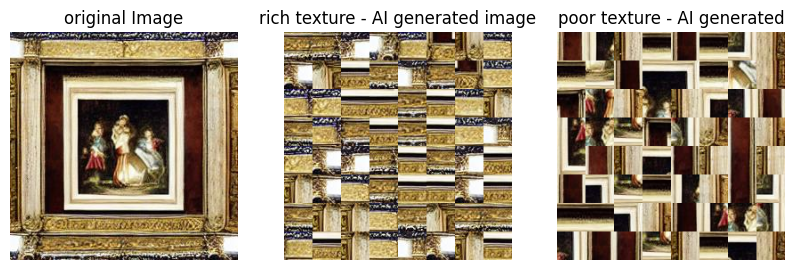

In [15]:
fake_image_path = random.sample(fake_imgs, 1)[0]

rt1, pt1 = smash_n_reconstruct(fake_image_path)

original_image = plt.imread(fake_image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rt1)
plt.title("rich texture - AI generated image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pt1)
plt.title("poor texture - AI generated")
plt.axis("off")

plt.show()

##### Applying high pass filters

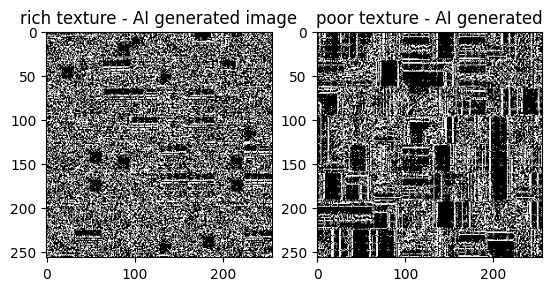

In [16]:
rt1 = apply_all_filters(rt1)
pt1 = apply_all_filters(pt1)

plt.subplot(1, 2, 1)
plt.imshow(rt1, cmap="gray")
plt.title("rich texture - AI generated image")
plt.subplot(1, 2, 2)
plt.imshow(pt1, cmap="gray")
plt.title("poor texture - AI generated")
plt.show()

##### Processing Real Image - Smash and Reconstruct + High Pass Filters

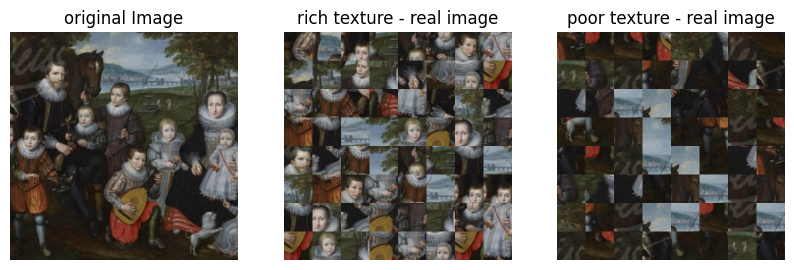

In [17]:
real_image_path = random.sample(real_imgs, 1)[0]

rt2, pt2 = smash_n_reconstruct(real_image_path)

original_image = plt.imread(real_image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rt2)
plt.title("rich texture - real image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pt2)
plt.title("poor texture - real image")
plt.axis("off")

plt.show()

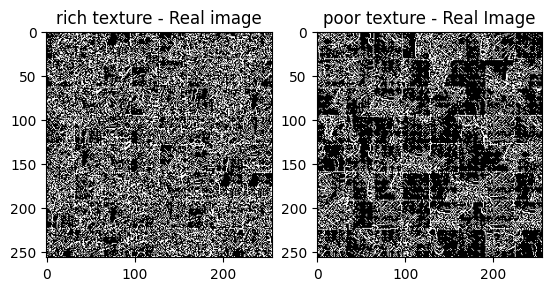

In [18]:
plt.subplot(1, 2, 1)
plt.imshow(apply_all_filters(rt2), cmap="gray")
plt.title("rich texture - Real image")
plt.subplot(1, 2, 2)
plt.imshow(apply_all_filters(pt2), cmap="gray")
plt.title("poor texture - Real Image")
plt.show()

##### Contrast Image

I0000 00:00:1746993217.389031      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746993217.389687      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


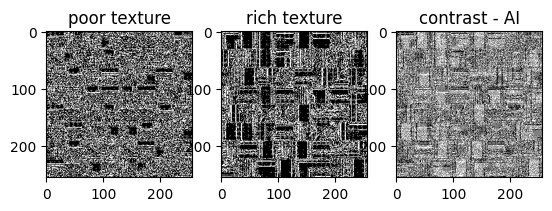

In [19]:
frt, fpt, label = preprocess(fake_image_path, 1)

plt.subplot(1, 3, 1)
plt.imshow(frt, cmap="gray")
plt.title("poor texture")
plt.subplot(1, 3, 2)
plt.imshow(fpt, cmap="gray")
plt.title("rich texture")
plt.subplot(1, 3, 3)
plt.imshow(frt - fpt, cmap="gray")
plt.title(f"contrast - {'AI' if label == 1 else 'Real'}")
plt.show()

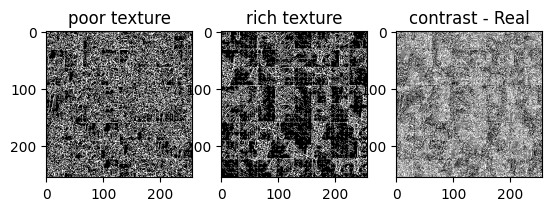

In [20]:
frt, fpt, label = preprocess(real_image_path, 0)

plt.subplot(1, 3, 1)
plt.imshow(frt, cmap="gray")
plt.title("poor texture")
plt.subplot(1, 3, 2)
plt.imshow(fpt, cmap="gray")
plt.title("rich texture")
plt.subplot(1, 3, 3)
plt.imshow(frt - fpt, cmap="gray")
plt.title(f"contrast - {'AI' if label == 1 else 'Real'}")
plt.show()

### Training Pipeline

In [21]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")
else:
    print("No GPUs available.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [22]:
tf.__version__

'2.18.0'

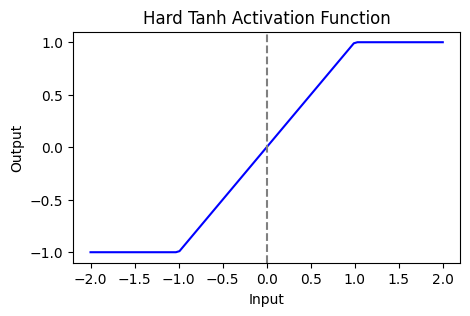

In [23]:
@tf.function
def hard_tanh(x) -> tf.Tensor:
    return tf.maximum(tf.minimum(x, 1), -1)

x_values = np.linspace(-2, 2, 100)
y_values = hard_tanh(tf.convert_to_tensor(x_values)).numpy()

plt.figure(figsize=(5, 3))
plt.plot(x_values, y_values, color="blue")
plt.title("Hard Tanh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.axvline(0, color="gray", linestyle="--")
plt.show()

##### Dataset Loading

In [24]:
def dict_map(X1, X2, y):
    return {"rich_texture": X1, "poor_texture": X2}, y

def set_shapes(frt, fpt, label=None):
    frt.set_shape(input_shape)
    fpt.set_shape(input_shape)
    if label is not None:
        label.set_shape([])
        return frt, fpt, label
    else:
        return frt, fpt

dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train), seed)
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

validation_set = (
    tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
    .map(
        lambda filepath, label: tf.py_function(
            preprocess, [filepath, label], [tf.float64, tf.float64, tf.int32]
        )
    )
    .map(set_shapes)
    .map(dict_map)
    .batch(10)
    .prefetch(tf.data.AUTOTUNE)
)

In [25]:
Counter(y_train)

Counter({1: 3500, 0: 3500})

In [26]:
Counter(y_validate)

Counter({0: 1500, 1: 1500})

##### Model Architecture

In [27]:
class FeatureExtractionLayer(layers.Layer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")
        self.bn = layers.BatchNormalization()
        self.activation = layers.Lambda(hard_tanh)

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.activation(x)
        return x

input0 = layers.Input(shape=input_shape, name="rich_texture")
input1 = layers.Input(shape=input_shape, name="poor_texture")

l0 = FeatureExtractionLayer(name="feature_extraction_layer_rich_texture")(input0)
l1 = FeatureExtractionLayer(name="feature_extraction_layer_poor_texture")(input1)

x = layers.subtract((l0, l1))

for i in range(4):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu")(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu")(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu")(x)
    x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(pool_size)(x)

for i in range(2):
    x = layers.Conv2D(filters=32, kernel_size=kernel_shape, activation="relu")(x)
    x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(
    inputs=(input0, input1), outputs=x, name="rt_pt_contrast"
)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.Precision()])
model.summary()

Model: "rt_pt_contrast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rich_texture (InputLayer) │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ poor_texture (InputLayer) │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_extraction_layer… │ (None, 254, 254, 32)   │            448 │ rich_texture[0][0]     │
│ (FeatureExtractionLayer)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_extraction_layer… │ (None, 254, 254, 32)   │            448 │ poor_texture[0][0]     │
│ (FeatureExtractionLayer)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract (Subtract)       │ (None, 254, 254, 32)   │              0 │ feature_extraction_la… │
│                           │                        │                │ feature_extraction_la… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 252, 252, 32)   │          9,248 │ subtract[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 252, 252, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 250, 250, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 250, 250, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 248, 248, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 248, 248, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 246, 246, 32)   │          9,248 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 246, 246, 32)   │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 123, 123, 32)   │              0 │ batch_normalization_5… │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 121, 121, 32)   │          9,248 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6

 Total params: 94,689 (369.88 KB)

 Trainable params: 93,921 (366.88 KB)

 Non-trainable params: 768 (3.00 KB)

### Model Training

In [28]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True,
)

history = model.fit(
    dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_set,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

Epoch 1/12


I0000 00:00:1746993249.818530     490 service.cc:148] XLA service 0x7f30a82aa700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746993249.819452     490 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746993249.819478     490 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746993252.697290     490 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-11 19:54:28.700344: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,254,254]{3,2,1,0}, f32[32,32,252,252]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0",

218/219 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - binary_accuracy: 0.8461 - loss: 0.3258 - precision: 0.8555 - recall: 0.8319 

2025-05-11 20:14:31.484152: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,32,254,254]{3,2,1,0}, f32[24,32,252,252]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-11 20:14:32.474017: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.989955301s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,32,254,254]{3,2,1,0}, f32[24,32,252,252]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

219/219 ━━━━━━━━━━━━━━━━━━━━ 1750s 8s/step - binary_accuracy: 0.8466 - loss: 0.3249 - precision: 0.8559 - recall: 0.8325 - val_binary_accuracy: 0.7537 - val_loss: 0.7514 - val_precision: 0.7132 - val_recall: 0.8487
Epoch 2/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1649s 8s/step - binary_accuracy: 0.9482 - loss: 0.1286 - precision: 0.9444 - recall: 0.9515 - val_binary_accuracy: 0.7920 - val_loss: 0.6834 - val_precision: 0.9899 - val_recall: 0.5900
Epoch 3/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1649s 8s/step - binary_accuracy: 0.9665 - loss: 0.0944 - precision: 0.9620 - recall: 0.9729 - val_binary_accuracy: 0.7950 - val_loss: 0.6300 - val_precision: 0.9966 - val_recall: 0.5920
Epoch 4/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1655s 8s/step - binary_accuracy: 0.9610 - loss: 0.1058 - precision: 0.9565 - recall: 0.9644 - val_binary_accuracy: 0.8910 - val_loss: 0.3258 - val_precision: 0.8319 - val_recall: 0.9800
Epoch 5/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 1661s 8s/step - binary_accuracy: 0.9706 - loss: 0.0798 - precision:

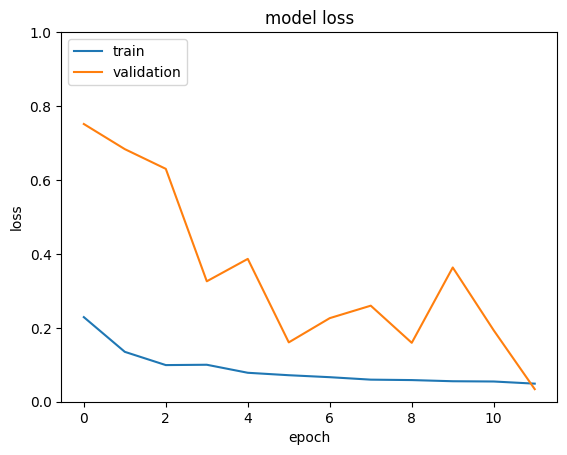

In [33]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.ylim(0, 1)

plt.show()

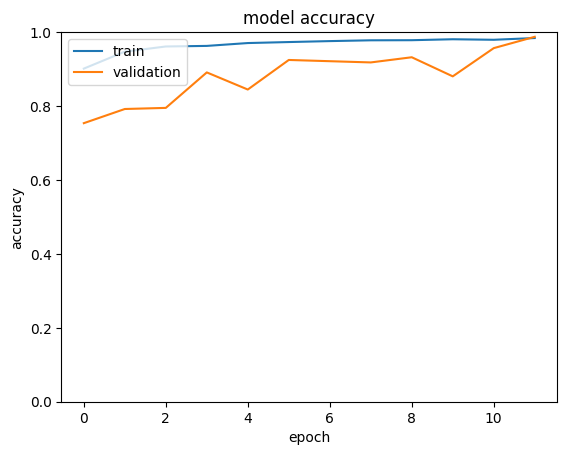

In [34]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.ylim(0, 1)

plt.show()

In [39]:
def save_model(model_id: str, model: Model, params: dict):
    model_path = f"{model_id}.keras"
    model.save(model_path)
    params["history"] = history.history
    with open(f"{model_id}.json", "w") as f:
        json.dump(params, f, indent=4)

    return model_path

In [40]:
model_path = save_model(model_id, model, params)

In [46]:
def inference(model_path: str, images_path: Union[str, List[str]]):
    custom_objects = {
        'FeatureExtractionLayer': FeatureExtractionLayer
    }
    model = models.load_model(model_path, custom_objects=custom_objects)

    if isinstance(images_path, str):
        images_path = [os.path.join(images_path, fname) for fname in os.listdir(images_path)]

    dummy_labels = [0] * len(images_path)
    dataset = tf.data.Dataset.from_tensor_slices((images_path, dummy_labels))

    dataset = dataset.map(  
        lambda path, label: tf.py_function(
            preprocess, [path, label], [tf.float64, tf.float64, tf.int32]
        )
    )

    dataset = dataset.map(set_shapes)
    dataset = dataset.map(lambda frt, fpt, label: {'rich_texture': frt, 'poor_texture': fpt})
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    predictions = model.predict(dataset, batch_size=batch_size)

    return predictions

In [42]:
base_test_path = "/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/"
X_test, y_test = read_dataset(base_test_path, fraction=0.1)

In [ ]:
preds_proba = inference(model_path, X_test)

In [61]:
preds = (np.array(preds_proba) > 0.5).astype(int)

In [57]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [62]:
accuracy_test = accuracy_score(y_test, preds)
precision_test = precision_score(y_test, preds)
recall_test = recall_score(y_test, preds)
f1_test = f1_score(y_test, preds)

print("\nReal_AI_SD_LD_Dataset Test Metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")


Real_AI_SD_LD_Dataset Test Metrics:
Accuracy: 0.9850
Precision: 0.9718
Recall: 0.9990
F1 Score: 0.9852
